$$\textbf{Problems 8.8 and 8.9}$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
N = 128 #sets the grid size 
x = np.random.rand(N,N)

In [13]:
for i in range(0,N):
    for j in range(0,N):
        if x[i,j] < 0.5:
            x[i,j]=1
        else:
            x[i,j]=-1 #Generates a T= inf state

In [14]:
#x=np.ones((N,N)) # Generates a array with all +1; i.e , a T=0 state

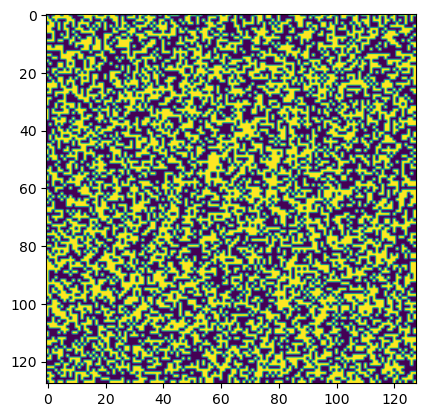

In [15]:
plt.imshow(x)

In [16]:
# Gives us the energy associated with single spin
def spin(x,i,j):
    if i==N-1 and j==N-1:
        return x[i,j]*(x[i,j-1] + x[0,j] + x[i,0] + x[i-1,j]) 
    elif i==N-1:
        return x[i,j]*(x[i,j-1] + x[0,j] + x[i,j+1] + x[i-1,j])
    elif j==N-1:
        return x[i,j]*(x[i,j-1] + x[i+1,j] + x[i,0] + x[i-1,j])
    else:
        return x[i,j]*(x[i,j-1] + x[i+1,j] + x[i,j+1] + x[i-1,j]) 

In [17]:
#Gives us the energy of the state
def Energy(array):
    Enn=0
    for i in range(0,N):
        for j in range(0,N): 
            Enn = Enn - spin(array,i,j)
    return (1/2)*Enn

In [18]:
#Gives us the magnetisation of the state
def mag(array):
    return array.sum()

In [55]:
#This function implements the metropolis algorithm and calculates the needed quantities
def equilibrate(x,T):
    y=x.copy()
    states = [x]
    states_ = [x]
    H = Energy(y)
    m = mag(y)
    E_calc=[H]
    M_calc=[m]
    
    for i in range(1,1+(3*10**6)):
        p = np.random.randint(0,N)
        q = np.random.randint(0,N)
        spin_i=y[p,q]
        dE = 2*spin(y,p,q)
        if dE <=0:
            y[p,q]=-y[p,q]
            E_new = H + dE
            m_new= m +(-2)*spin_i
            y_new=y.copy()
        else:
            temp=np.random.rand()
            prob = np.exp(-(dE)/T)
            if temp < prob:
                y[p,q]=-y[p,q]
                E_new = H + dE
                m_new= m +(-2)*spin_i
                y_new=y.copy()
            else:
                E_new = H
                m_new = m
                y_new=y.copy()
        H = E_new
        m = m_new
        E_calc.append(E_new)
        M_calc.append(m_new)
        if i % 10**5 == 0:
            states_.append(y_new)
        if i > 2*10**6 and i % N**2 ==0:
            states.append(y_new)
    
    E_calc = np.array(E_calc)
    M_calc = np.array(M_calc)
    states=np.array(states)
    
    
    
    return E_calc, M_calc ,states, states_

In [56]:
Es,Ms,states,states_ = equilibrate(x,1)

Text(0, 0.5, 'Energy of the system')

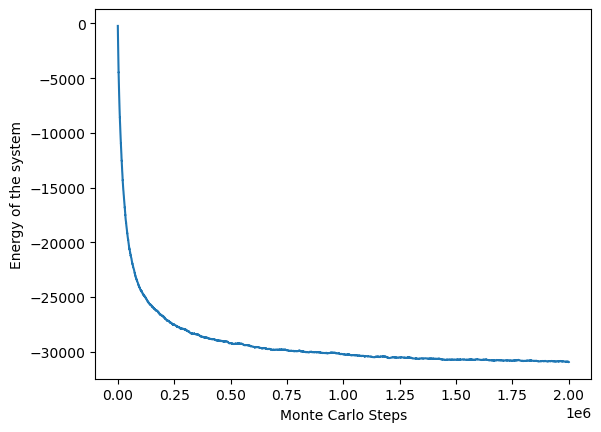

In [62]:
plt.plot(Es[:2*10**6])
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Energy of the system')

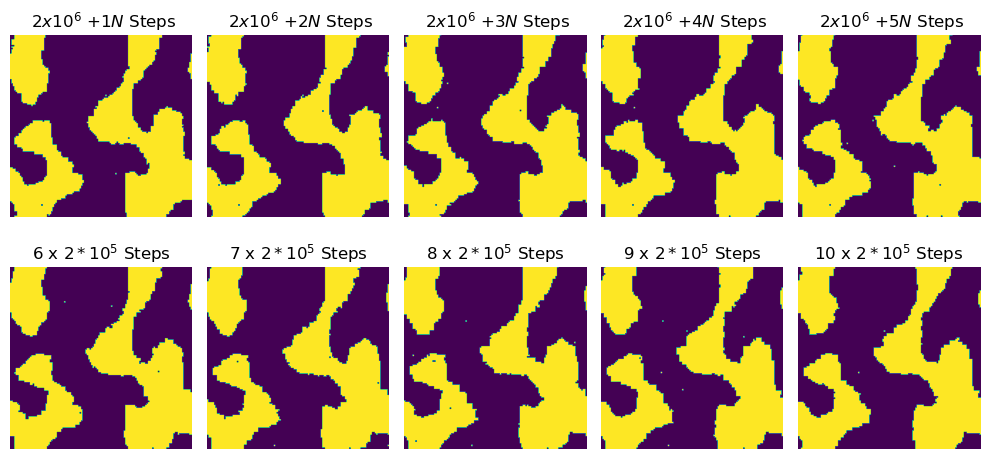

In [83]:
# Create subplots with GridSpec
fig = plt.figure(figsize=(10, 5))
grid = fig.add_gridspec(2, 5)  # 3 rows, 5 columns

# Second row (5 images)
for i in range(1,6):
    ax = fig.add_subplot(grid[0, i-1])  # Second row
    im = ax.imshow(states[i], cmap='viridis')
    ax.set_title(f" $2 x 10^6$ +{i}$N$ Steps")  # Titles from Array 2 to Array 6
    ax.axis('off')


# Second row (5 images)
for i in range(1,6):
    ax = fig.add_subplot(grid[1, i-1])  # Second row
    im = ax.imshow(states[i+5], cmap='viridis')
    ax.set_title(f"{i+5} x $2*10^5$ Steps")  # Titles from Array 2 to Array 6
    ax.axis('off')


# Adjust layout
plt.tight_layout()
plt.savefig("T=0to T =2.8, 2x10^6.png", format='png', dpi=300)


$$\textbf{Wolff Algorithm}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# Setting the Periodic Boundary Conditions
def PBC_down(i,j):
    if i==N-1:
        return 0,j
    else:
        return i+1,j
def PBC_right(i,j):
    if j == N-1:
        return i,0
    else:
        return i,j+1
def PBC_up(i,j):
    if i==0:
        return N-1,j
    else:
        return i-1,j
def PBC_left(i,j):
    if j==0:
        return i, N-1
    else:
        return i,j-1

In [86]:
#Acceptance probability
def p(T):
    return 1 - np.exp(-2/T)


#Checking if we accept or not
def acc(T):
    x = np.random.rand()
    return x < p(T)

#Finds the clusters
def find_cluster(T, arr, i, j):
    spin = arr[i, j]
    cluster = [(i, j)]
    stack = [(i, j)]
    visited = set(stack)

    while stack:
        ci, cj = stack.pop()
        
        # Check all neighbors
        neighbors = [PBC_up(ci, cj), PBC_left(ci, cj), PBC_right(ci, cj), PBC_down(ci, cj)]
        for ni, nj in neighbors:
            if (ni, nj) not in visited and arr[ni, nj] == spin:
                if acc(T):
                    cluster.append((ni, nj))
                    stack.append((ni, nj))
                    visited.add((ni, nj))

    return cluster

In [87]:
def Wolff(x, T):
    y = x.copy()
    states = [y.copy()]  # Storing initial state
    mags = [mag(y)]
    Energies = [Energy(y)]
    for i in range(1+ 75):
        # Random starting point for the cluster
        p = np.random.randint(0, N)
        q = np.random.randint(0, N)
        
        # Find the clusters
        cluster = find_cluster(T, y, p, q)
        
        # Flip the spins in the cluster
        for pos in cluster:
            y[pos] = -y[pos]

        
        mags.append(mag(y))
        Energies.append(Energy(y))
        
        # Save state at intervals
        if i % 1 == 0:
            states.append(y.copy())
    
    return states, mags, Energies

In [88]:
N = 128 #sets the grid size 
x = np.random.rand(N,N)
for i in range(0,N):
    for j in range(0,N):
        if x[i,j] < 0.5:
            x[i,j]=1
        else:
            x[i,j]=-1 #Generates a T= inf state

In [89]:
%timeit Wolff(x,1)

2.87 s ± 755 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
#x=np.ones((N,N)) # Generates a array with all +1; i.e , a T=0 state

In [90]:
ss , ms , es = Wolff(x,1)

Text(0, 0.5, 'Energy of the system')

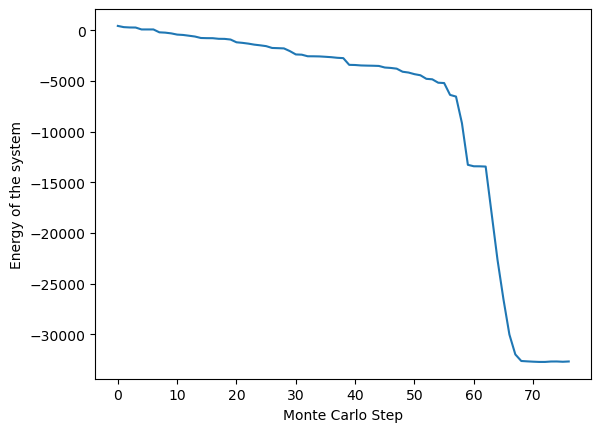

In [91]:
plt.plot(es)
plt.xlabel('Monte Carlo Step')
plt.ylabel('Energy of the system')

In [62]:
ss_=ss[:100]
ss_=ss_[::10]

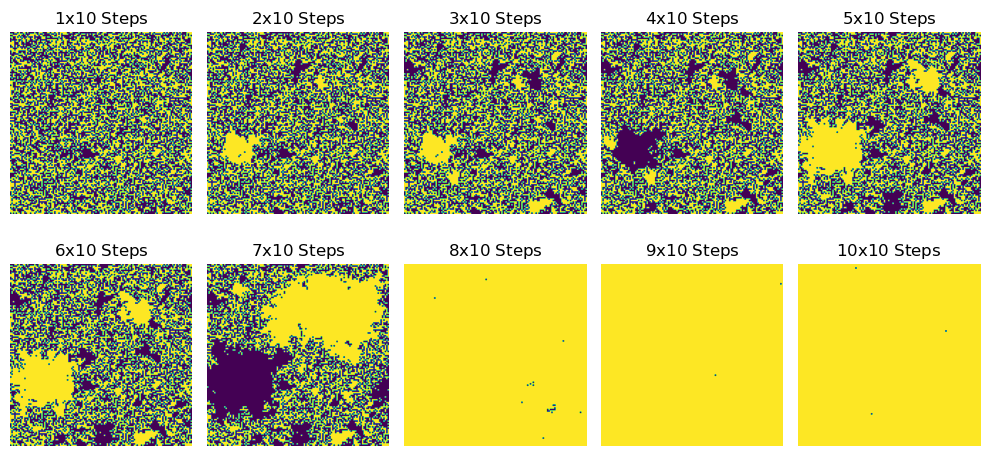

In [65]:
# Create subplots with GridSpec
fig = plt.figure(figsize=(10, 5))
grid = fig.add_gridspec(2, 5)  # 3 rows, 5 columns

# Second row (5 images)
for i in range(1,6):
    ax = fig.add_subplot(grid[0, i-1])  # Second row
    im = ax.imshow(ss_[i], cmap='viridis')
    ax.set_title(f"{i}x$10$ Steps")  # Titles from Array 2 to Array 6
    ax.axis('off')


# Second row (5 images)
for i in range(1,6):
    ax = fig.add_subplot(grid[1, i-1])  # Second row
    im = ax.imshow(ss_[i+4], cmap='viridis')
    ax.set_title(f"{i+5}x$10$ Steps")  # Titles from Array 2 to Array 6
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig("Wolff, T=inf to T=Tc", format='png', dpi=300)


$$\textbf{Problem 8.10 :Stochastic Cells}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(M, N, ku = 2 , kb = 1):
    return ku*(N-M) -2*kb*M**2

In [3]:
#Using Runge-Kutta of Order 4 (RK4) to numerically solve the differential equation , error scales as O(h^4)

def runge_kutta(t, N, nmax = 20000,tol =1.e-8):
    h = t/nmax
    M_0 = N
    for i in range(nmax):
        k1 = h*f(M_0,N)
        k2 = h*f(M_0 + 0.5*k1,N)
        k3 = h*f(M_0 + 0.5*k2,N)
        k4 = h* f(M_0 + k3,N)
        M_1 = M_0 + (k1 + 2*k2+ 2*k3+ k4)/6
        diff = (M_1-M_0)/M_0
        if abs(diff) < tol:
            break
        M_0 = M_1
    return M_1

In [180]:
ts = np.linspace(0,5,1000)
N = 2 #Change this as necessary
Ms = [runge_kutta(t,2) for t in ts] 
Ds = (N - np.array(Ms))/2

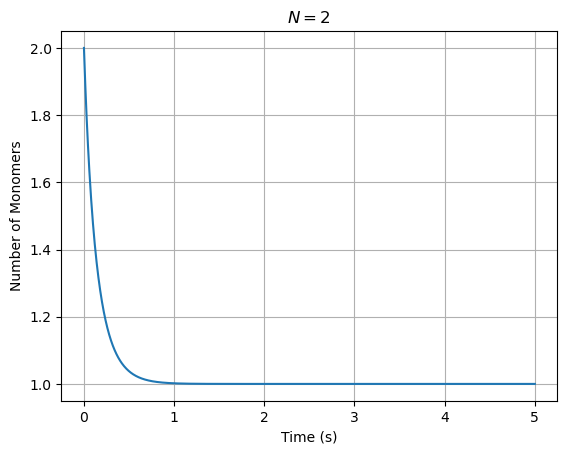

In [183]:
plt.plot(ts,Ms)
plt.xlabel('Time (s)')
plt.ylabel('Number of Monomers')
plt.title('$N=2$')
plt.grid()
plt.show()

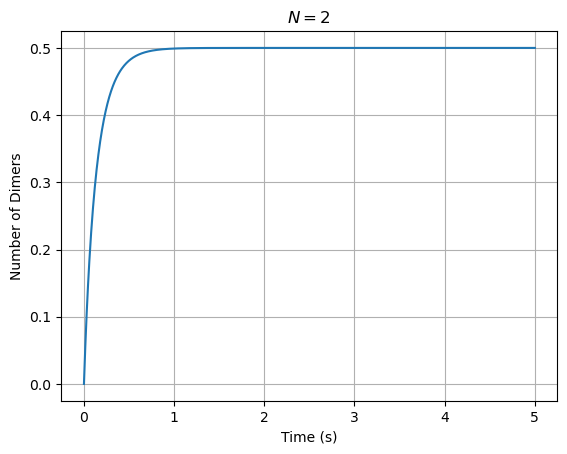

In [182]:
Ds = (2 - np.array(Ms))/2
plt.plot(ts,Ds)
plt.xlabel('Time (s)')
plt.ylabel('Number of Dimers')
plt.title('$N=2$')
plt.grid()
plt.show()

In [187]:
ts_ = np.linspace(0,3,1000)
Ms_ = [runge_kutta(t,90) for t in ts] 
Ds_ = (90 - np.array(Ms))/2

In [193]:
npMs = np.array(Ms_)

In [194]:
ks = (90 - npMs)/2

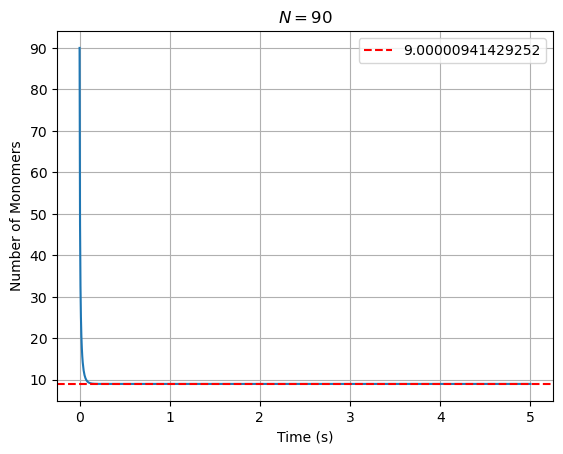

In [206]:
plt.plot(ts,Ms_)
plt.axhline(y = Ms_[-1], color = 'r', linestyle = 'dashed', label = "{}".format(Ms_[-1]))
plt.xlabel('Time (s)')
plt.ylabel('Number of Monomers')
plt.title('$N=90$')
plt.grid()
plt.legend()
plt.show()

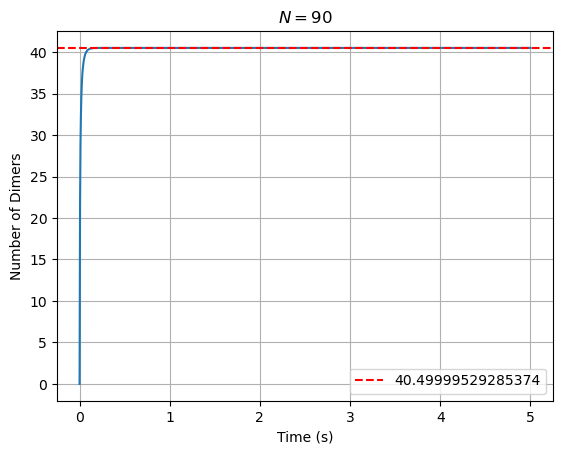

In [204]:
plt.plot(ts,ks)
plt.axhline(y = ks[-1], color = 'r', linestyle = 'dashed', label = "{}".format(ks[-1]))
plt.xlabel('Time (s)')
plt.ylabel('Number of Dimers')
plt.title('$N=90$')
plt.grid()
plt.legend()
plt.show()

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def eqv(N): #The analytical equilibrium points for N
    pm = np.array([+1, -1])
    Meq_1, Meq_2 = (-2 + pm* np.sqrt(4 +16*N))/4
    Deq_1 , Deq_2 = (N - Meq_1)/2 , (N-Meq_2)/2
    if Meq_1 <0:
        return [Meq_2,Deq_2]
    else:
        return [Meq_1,Deq_1]

In [3]:
def t_wait_gen(gamma_tot): #Generates t_wait
    u = np.random.rand()
    return (-1/gamma_tot)*np.log(1-u)

In [4]:
def cont_time_MC(mols_ini,k_b,k_u,t_f): #Complete Algorithm for Continuous Time Monte-Carlo simulation for the dimerisation reaction
    mols = np.array(mols_ini)
    mols_t =[mols]
    ts = [0]
    t = 0
    t_wait = 0
    while (t+t_wait) < t_f:
        M , D = mols
        rate_1 = k_b * int(M)* (int(M)-1)
        rate_2 = k_u *int(D)
        rate_tot = rate_1 + rate_2
        t_wait = t_wait_gen(rate_tot)
        r = rate_tot * np.random.rand()
        if r<rate_1:
            M = M-2
            D = D +1
        else:
            M = M+2
            D= D-1
        mols = [M,D]
        mols_t.append(mols)
        t = t + t_wait
        ts.append(t)
    return mols_t , ts

In [5]:
#Initial values for simulation
k_u = 2
k_b = 1
N = 7*10**4
mols_ini = [N,0]
t_f = 5

In [6]:
#Simulating, then separating the M(t) and D(t) numbers for plotting
mols_over_t ,times = cont_time_MC(mols_ini,k_b,k_u,t_f)
M_t  = [mols[0] for mols in mols_over_t]
D_t = [mols[1] for mols in mols_over_t]

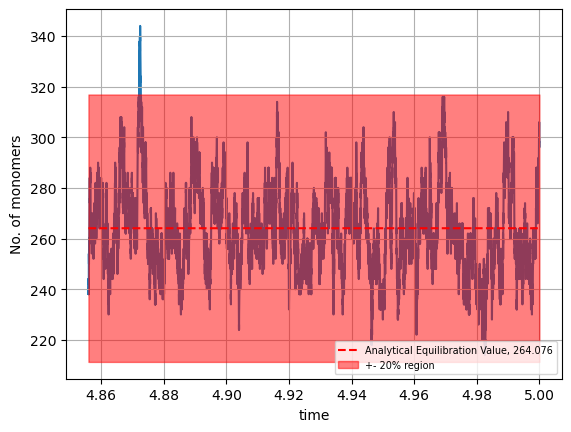

In [7]:
#Plotting M(t)

#times = np.linspace(0,t_f,len(M_t)) # x-axis
#region to plot (Use to magnify)
k= 2*10**4
times_plt = times[-k:]
M_t_plt = M_t[-k:]

plt.plot(times_plt,M_t_plt,zorder=1) #Data
plt.plot(times_plt, np.full_like(times_plt, eqv(N)[0]), color='red', linestyle='dashed', label="Analytical Equilibration Value, {}".format(round(eqv(N)[0],3)), zorder=2) #The analytical equilibrium value

# Define the region +/- 20%
y_upper = eqv(N)[0] * 1.2
y_lower = eqv(N)[0] * 0.8

# Fill the region between the upper and lower bounds
plt.fill_between(times_plt,y_lower, y_upper, color='red', alpha=0.5, label='+- 20% region',zorder=3)

#plt.locator_params(axis='y', nbins=10)
plt.xlabel('time')
plt.ylabel('No. of monomers')
plt.grid()
plt.legend(loc = 'lower right',fontsize='x-small')

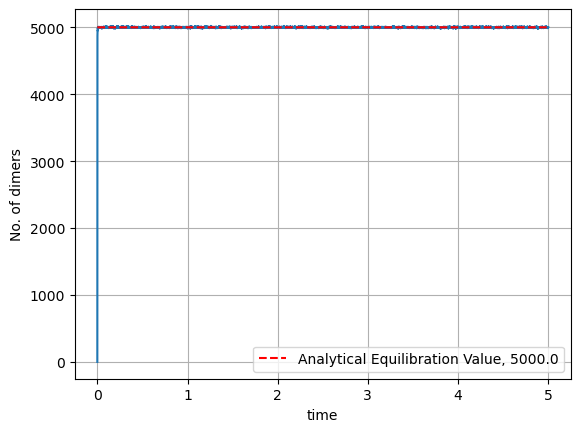

In [189]:
times_plt = times[-k:]
D_t_plt = D_t[-k:]
plt.plot(times_plt,D_t_plt)
plt.plot(times_plt, np.full_like(times_plt, eqv(N)[1]), color='red', linestyle='dashed', label="Analytical Equilibration Value, {}".format(eqv(N)[1]), zorder=2)
plt.xlabel('time')
plt.ylabel('No. of dimers')
plt.locator_params(axis='y', nbins=10)
plt.grid()
plt.legend(loc = 'lower right')

The following 7 cells are the binning method for ensemble averaging as mentioned in the report.

In [ ]:
def merge_multiple_dicts(dict_list): #Use this in ensemble averaging the different simulations as different simulations can have different time steps.
    # Initialize an empty dictionary to hold the merged result
    dict3 = {}

    # Combine all keys from all dictionaries
    all_keys = set().union(*dict_list)

    # Iterate through each key
    for key in all_keys:
        # Collect all the values for the current key from each dictionary
        values = [d.get(key) for d in dict_list if key in d]
        
        if values:
            # If the key exists in at least one dictionary, average the values
            dict3[key] = sum(values) / len(values)
        else:
            # If the key is not found in any dictionary (though this case won't happen due to union of keys)
            dict3[key] = None  # or handle as per your need

    return dict3

In [9]:
def sort_dict_and_create_lists(input_dict):
    # Sort the dictionary by keys
    sorted_dict = dict(sorted(input_dict.items()))

    # Create lists from the sorted dictionary
    keys_list = list(sorted_dict.keys())
    values_list = list(sorted_dict.values())

    return keys_list, values_list

In [10]:
def time_binner(dict, binsize, time_bins):
    # Create a new dictionary where the times are replaced by their corresponding bin
    newdict = {}
    for key, value in dict.items():
        # Find the closest bin in the time_bins array
        closest_bin = min(time_bins, key=lambda x: abs(x - key))
        newdict[closest_bin] = value
    return newdict

In [32]:
def ensemble(mols_ini, k_b, k_u, t_f, nmax=100):
    # Lists to hold all M(t) and D(t) time series
    M_dicts = []
    D_dicts = []
    avg_times = 0 
    # Run multiple simulations and collect time:M and time:D dictionaries
    for _ in range(nmax):
        mols_over_t ,times = cont_time_MC(mols_ini,k_b,k_u,t_f)
        M_t  = [mols[0] for mols in mols_over_t]
        D_t = [mols[1] for mols in mols_over_t]
        
        # Create dictionary for M(t) and D(t)
        M_dict = dict(zip(times, [m for m in M_t]))  # M(t) dictionary
        D_dict = dict(zip(times, [d for d in D_t]))  # D(t) dictionary
        
        M_dicts.append(M_dict)
        D_dicts.append(D_dict)
        avg_times += len(times)
    avg_times = int(avg_times/nmax)
    time_bins = np.linspace(0, t_f, avg_times)
    binsize = time_bins[3] - time_bins[2]
    
    binned_M_dicts= []
    binned_D_dicts= []
    for m_dict in M_dicts:
        binned_M_dicts.append(time_binner(m_dict,binsize,time_bins))
    for d_dict in D_dicts:
        binned_D_dicts.append(time_binner(d_dict,binsize,time_bins))
    
    M_ensbl_dict = merge_multiple_dicts(binned_M_dicts)
    D_ensbl_dict = merge_multiple_dicts(binned_D_dicts)

    ts_M , Ms = sort_dict_and_create_lists(M_ensbl_dict)
    ts_D , Ds = sort_dict_and_create_lists(D_ensbl_dict)
    return ts_M , Ms , ts_D , Ds

In [39]:
#Initial values for simulation
k_u = 2
k_b = 1
N = 1000
mols_ini = [N,0]
t_f = 1

In [40]:
ts_M ,Ms, ts_D ,Ds = ensemble(mols_ini,k_b,k_u,t_f)

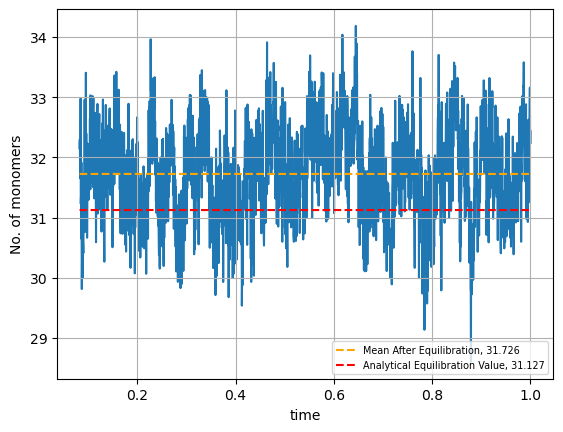

In [42]:
#Plotting M(t)

#times = np.linspace(0,t_f,len(M_t)) # x-axis
#region to plot (Use to magnify)
k= 2*10**2
times_plt = ts_M[k:]
M_t_plt = Ms[k:]

mean = (np.array(M_t_plt)).mean()
plt.plot(times_plt,M_t_plt,zorder=1) #Data
plt.plot(times_plt, np.full_like(times_plt, mean), color='orange', linestyle='dashed', label="Mean After Equilibration, {}".format(round(mean,3), zorder=2)) #The analytical equilibrium value
plt.plot(times_plt, np.full_like(times_plt, eqv(N)[0]), color='red', linestyle='dashed', label="Analytical Equilibration Value, {}".format(round(eqv(N)[0],3)), zorder=2) #The analytical equilibrium value

# Define the region +/- 20%
y_upper = eqv(N)[0] * 1.2
y_lower = eqv(N)[0] * 0.8

# Fill the region between the upper and lower bounds
#plt.fill_between(times_plt,y_lower, y_upper, color='red', alpha=0.5, label='+- 20% region',zorder=3)

#plt.locator_params(axis='y', nbins=10)
plt.xlabel('time')
plt.ylabel('No. of monomers')
plt.grid()
plt.legend(loc = 'lower right',fontsize='x-small')

The following is the interpolation approach for ensemble averaging.

In [47]:
def ensmbl_inter(N, nAverage, tMax=1.0, dt=0.001):
    times = np.arange(dt, tMax + dt, dt)
    M_avg = np.zeros_like(times)
    D_avg = np.zeros_like(times)

    for _ in range(nAverage):
        mols_over_t, stochasticTimes = cont_time_MC([N, 0], k_b, k_u, tMax)
        
        M_t = [mols[0] for mols in mols_over_t]
        D_t = [mols[1] for mols in mols_over_t]
        
        # Find indices in stochasticTimes that are closest to `times` grid
        indices = np.searchsorted(stochasticTimes, times)
        
        # Interpolate M and D values at these indices
        interpolated_M = [M_t[idx-1] if idx > 0 else M_t[0] for idx in indices]
        interpolated_D = [D_t[idx-1] if idx > 0 else D_t[0] for idx in indices]

        # Accumulate for averaging
        M_avg += np.array(interpolated_M)
        D_avg += np.array(interpolated_D)
    
    # Final average
    M_avg /= nAverage
    D_avg /= nAverage
    
    return times , M_avg, D_avg

In [105]:
#Initial values for simulation
k_u = 2
k_b = 1
N = 200
mols_ini = [N,0]
t_f = 5

In [106]:
times , Ms , Ds = ensmbl_inter(N, 100 , t_f)

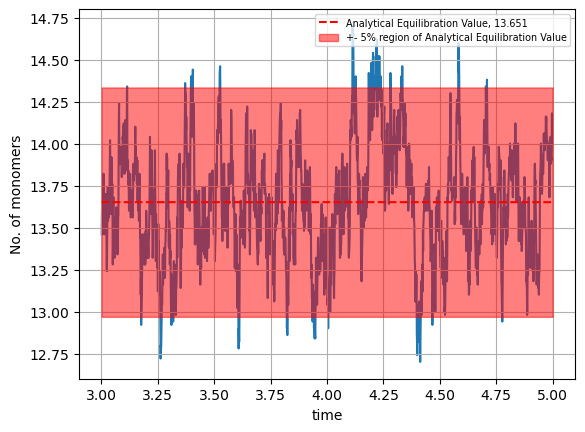

In [107]:
#Plotting M(t)

#times = np.linspace(0,t_f,len(M_t)) # x-axis
#region to plot (Use to magnify)
k= 2000
times_plt = times[-k:]
M_t_plt = Ms[-k:]

mean = (np.array(M_t_plt[-2000:])).mean()
plt.plot(times_plt,M_t_plt,zorder=1) #Data
#plt.plot(times_plt, np.full_like(times_plt, mean), color='orange', linestyle='dashed', label="Mean After Equilibration, {}".format(round(mean,3), zorder=2)) #The analytical equilibrium value
plt.plot(times_plt, np.full_like(times_plt, eqv(N)[0]), color='red', linestyle='dashed', label="Analytical Equilibration Value, {}".format(round(eqv(N)[0],3)), zorder=2) #The analytical equilibrium value

# Define the region +/- 20%
y_upper = eqv(N)[0] * 1.05
y_lower = eqv(N)[0] * 0.95

# Fill the region between the upper and lower bounds
plt.fill_between(times_plt,y_lower, y_upper, color='red', alpha=0.5, label='+- 5% region of Analytical Equilibration Value',zorder=3)

#plt.locator_params(axis='y', nbins=10)
plt.xlabel('time')
plt.ylabel('No. of monomers')
plt.grid()
plt.legend(loc = 'upper right',fontsize='x-small')